In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 도시 딕셔너리
city_dict = {
    '서울특별시': 'seoul',
    '경기도': 'gyeonggi',
    '인천광역시': 'incheon',
    '부산광역시': 'busan',
    '대구광역시': 'daegu',
    '광주광역시': 'gwangju',
    '대전광역시': 'daejeon',
    '울산광역시': 'ulsan'
}

# 수도권 도시 리스트
capital_region_cities = ['seoul', 'gyeonggi', 'incheon']

In [3]:
def merge_per_city(city_name: str) -> pd.DataFrame:
    """
    주어진 도시의 2010~2019 CSV 파일을 읽어와서 하나의 DataFrame으로 합칩니다.
    불필요한 컬럼을 삭제하고 파생 컬럼을 추가합니다.
    (권역, 계약월, 계약계절, 면적구간, 평당가, 건축연수, 신축여부)
    """
    merged_data = {}
    sep = 'c' if city_name in capital_region_cities else 'p'

    for year in range(2010, 2020):
        file_path = f'./raw_data/{sep}_{city_name}_{year}.csv'
        merged_data[year] = pd.read_csv(file_path, encoding='EUC-KR', header=15)

    # 권역 컬럼 추가 후 합치기
    df_list = []
    for year, df in merged_data.items():
        df = df.copy()
        df_list.append(df)

    df_merged = pd.concat(df_list, ignore_index=True)

    # 삭제할 컬럼명 리스트
    all_dash_cols = (df_merged == '-').sum() == df_merged.shape[0]
    cols_to_drop = list(all_dash_cols[all_dash_cols].index)
    for col in ['NO', '도로명']:
        if col in df_merged.columns:
            cols_to_drop.append(col)

    # 컬럼 삭제
    df_merged = df_merged.drop(columns=cols_to_drop)

    # 권역 컬럼 추가
    region_flag = '수도권' if sep == 'c' else '지방'
    df_merged['권역'] = region_flag

    # 계약년도 추출
    df_merged['계약년도'] = df_merged['계약년월'] // 100

    # 계약월 추출
    df_merged['계약월'] = df_merged['계약년월'] % 100

    # 거래금액 처리
    df_merged['거래금액(만원)'] = (df_merged['거래금액(만원)'].astype(str).str.replace(',', '', regex=False).astype(int))

    # 평당가 컬럼 추가
    df_merged['price_per_m2'] = (df_merged['거래금액(만원)'] / df_merged['전용면적(㎡)']).round(1)

    # 건축연수 컬럼 추가
    df_merged['building_age'] = df_merged['계약년도'] - df_merged['건축년도']

    # 면적 구간(area_bin) 컬럼 추가
    def categorize_area(area):
        if area <= 60:
            return '소형'
        elif area <= 85:
            return '중소형'
        elif area <= 135:
            return '중대형'
        elif area > 135:
            return '대형'
   
    df_merged['area_bin'] = df_merged['전용면적(㎡)'].apply(categorize_area)

    # 신축 여부 컬럼 추가
    df_merged['is_new_building'] = df_merged['building_age'] <= 5

    # 계약계절 컬럼 추가
    def season(month):
        if month in [3, 4, 5]:
            return '봄'
        elif month in [6, 7, 8]:
            return '여름'
        elif month in [9, 10, 11]:
            return '가을'
        elif month in [12, 1, 2]:
            return '겨울'

    df_merged['contract_season'] = df_merged['계약월'].apply(season)

    cols_order = ['권역', '시군구', '번지', '본번',  '부번',  '단지명', '계약년월', '계약년도', '계약월', '계약일', 'contract_season',  'area_bin', '전용면적(㎡)', '거래금액(만원)', 'price_per_m2',\
                  '층', '건축년도', 'building_age', 'is_new_building']
    df_merged = df_merged[[col for col in cols_order if col in df_merged.columns] + 
                        [col for col in df_merged.columns if col not in cols_order]]

    return df_merged

# 도시별 df를 모두 생성해서 딕셔너리에 저장
cities_df = {f'{eng}_raw': merge_per_city(eng) for eng in city_dict.values()}

## 도시별 데이터 프로파일링
결과 -> data_profile_output.html

In [ ]:
# from da_utils import profile

# for city_ko, city_en in city_dict.items():
#     print(f"# {city_ko} 실거래가 데이터 (2010~2019)")
#     profile.get_data_profile(cities_df[f"{city_en}_raw"])
#     print("\n")

In [ ]:
# import sys  # 호스(물줄기) 도구
# from io import StringIO  # 통(문자열 모으기) 도구
# from da_utils import profile

# html_content = ""  # 빈 앨범

# for city_ko, city_en in city_dict.items():
#     html_content += f"<h1># {city_ko} 실거래가 데이터 (2010~2019)</h1>"
    
#     # print 캡처 시작 (녹음기 켜기)
#     old_stdout = sys.stdout
#     sys.stdout = mystdout = StringIO()
    
#     # 함수 호출
#     result = profile.get_data_profile(cities_df[f"{city_en}_raw"])
    
#     # 캡처 끝과 텍스트 꺼내기
#     sys.stdout = old_stdout
#     captured_text = mystdout.getvalue()
    
#     # 캡처된 텍스트를 <pre>로 준비 (하지만 위치 조정 위해 문자열로 다뤄요)
#     pre_text = "<pre>" + captured_text + "</pre>"
    
#     # 표 HTML 만들기 (사진 준비)
#     table_html = ""
#     if isinstance(result, pd.DataFrame):
#         table_html = result.to_html()
#     elif hasattr(result, 'to_html'):
#         table_html = result.to_html()
    
#     # 이제 위치 조정: 텍스트를 "3. 수치형 변수 품질 분석" 다음에 표 끼워넣기
#     # 비유: 편지를 특정 문장으로 자르고 사진 붙이기
#     if table_html:  # 표가 있으면
#         # 텍스트를 줄 단위로 자르기 (splitlines()는 줄바꿈으로 나눠요)
#         text_lines = captured_text.splitlines()
#         inserted = False
#         adjusted_text = "<pre>"
        
#         for line in text_lines:
#             adjusted_text += line + "\n"  # 원래 줄 붙이기
#             if "3. 수치형 변수 품질 분석" in line:  # 이 줄 찾으면
#                 adjusted_text += "</pre>"  # pre 잠시 닫고
#                 adjusted_text += table_html  # 표 붙이기
#                 adjusted_text += "<pre>"  # pre 다시 열기 (줄바꿈 유지)
#                 inserted = True
        
#         adjusted_text += "</pre>"
        
#         if not inserted:  # 만약 "3." 못 찾으면 표를 끝에 붙임 (안전장치)
#             adjusted_text = pre_text + table_html

#         html_content += adjusted_text
#     else:
#         html_content += pre_text  # 표 없으면 텍스트만
    
#     html_content += "<br><br>"

# # 파일 저장 (이전과 같음)
# with open('data_profile_output.html', 'w', encoding='utf-8') as f:
#     f.write('<html><body>')
#     f.write(html_content)
#     f.write('</body></html>')

### 프로파일링 결과 바탕으로 한 **데이터 전처리** 방안

1. 건축연수 음수값 정리
2. 아파트별 거래금액 극단값 정리
3. 거래금액+평당가(price_per_m2) 로그 컬럼 추가
    - 실제 부동산 가격은 규모, 연식 등과 곱셈 관계(지수함수 형태)를 가지는 경우가 많음
    - 로그 변환으로 데이터를 선형화해야 회귀 분석 및 모델 해석이 용이함

In [6]:
# 1. 건축연수 음수값 정리
for city_ko, city_en in city_dict.items():
    mask = cities_df[f'{city_en}_raw']['building_age'] < 0
    print(f"=== {city_ko} 건축연수 음수값 조회 ===")
    print(cities_df[f"{city_en}_raw"][mask].groupby('building_age').size())

=== 서울특별시 건축연수 음수값 조회 ===
building_age
-1    37
dtype: int64
=== 경기도 건축연수 음수값 조회 ===
building_age
-1    71
dtype: int64
=== 인천광역시 건축연수 음수값 조회 ===
building_age
-1    3
dtype: int64
=== 부산광역시 건축연수 음수값 조회 ===
building_age
-1    4
dtype: int64
=== 대구광역시 건축연수 음수값 조회 ===
building_age
-1    4
dtype: int64
=== 광주광역시 건축연수 음수값 조회 ===
building_age
-1    3
dtype: int64
=== 대전광역시 건축연수 음수값 조회 ===
building_age
-1    1
dtype: int64
=== 울산광역시 건축연수 음수값 조회 ===
Series([], dtype: int64)


In [7]:
"""
건축연수가 -1인 경우는 아파트 사용승인일 전의 분양권 매매로 판단하여 건축연수 0으로 수정
"""

for city_ko, city_en in city_dict.items():
    cities_df[f"{city_en}_raw"].loc[cities_df[f"{city_en}_raw"]['building_age'] == -1, 'building_age'] = 0

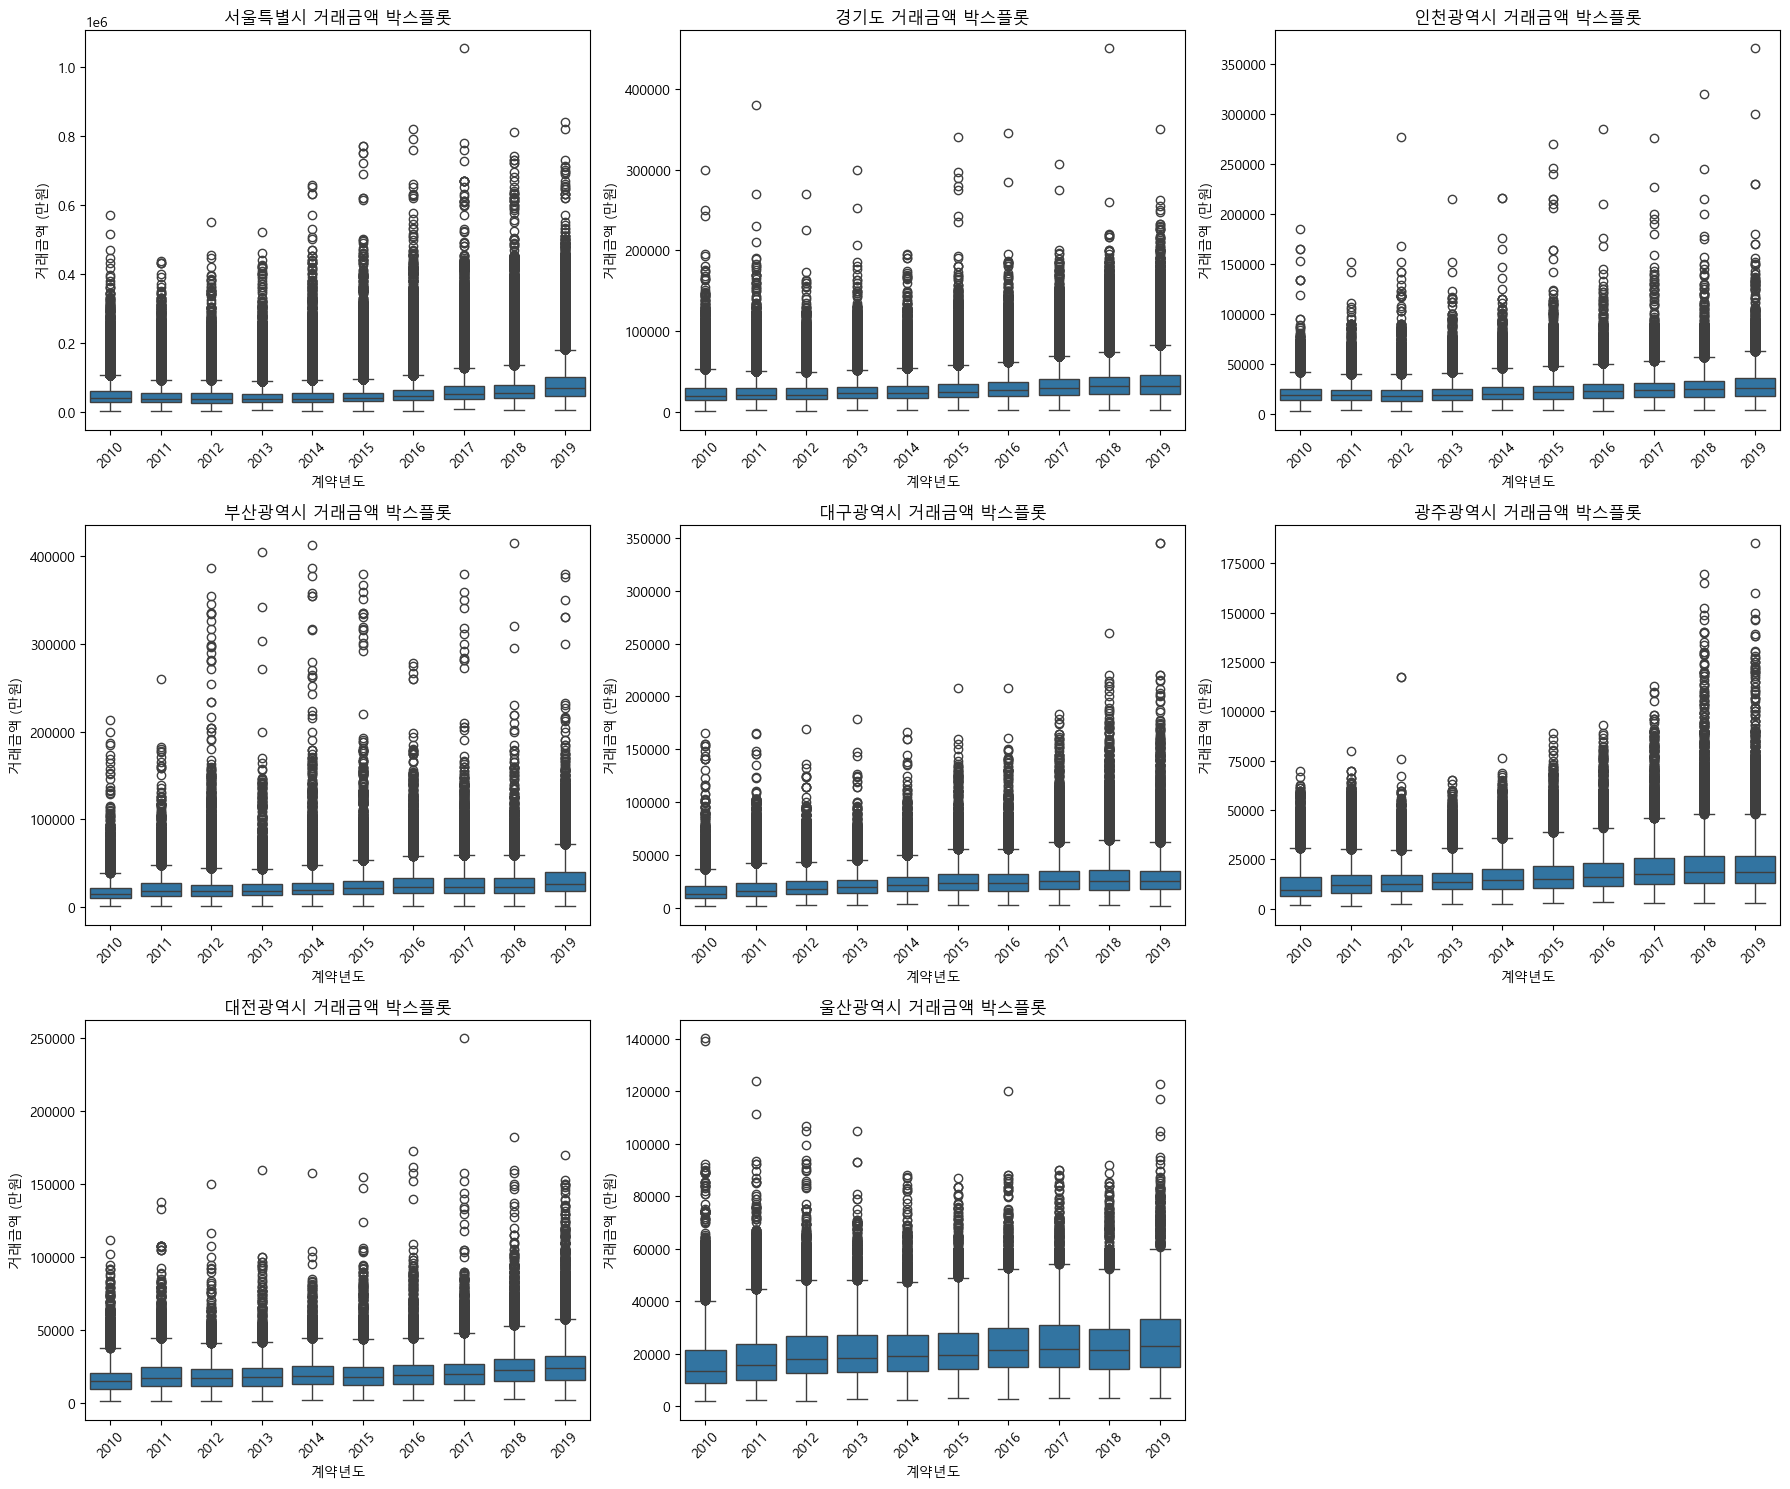

In [8]:
# 2. 아파트별 거래금액 극단값 정리

# 거래금액 박스플롯
n_cities = len(city_dict)
n_cols = 3  # 한 행에 3개 도시씩 표시
n_rows = (n_cities + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols*6, n_rows*5))

for i, (city_ko, city_en) in enumerate(city_dict.items()):
    df = cities_df[f'{city_en}_raw']
    
    plt.subplot(n_rows, n_cols, i+1)
    sns.boxplot(x='계약년도', y='거래금액(만원)', data=df)

    plt.title(f"{city_ko} 거래금액 박스플롯")
    plt.xticks(rotation=45)
    plt.ylabel("거래금액 (만원)")
    plt.xlabel("계약년도")

plt.tight_layout()
plt.show()

In [ ]:
# 거래금액 0원 이하 값 확인
for name, df in cities_df.items():
    if (df['거래금액(만원)'] <= 0).any():
        print(f"{name}: 0 이하 값 존재")
    else:
        print(f"{name}: 이상 없음")

seoul_raw: 이상 없음
gyeonggi_raw: 이상 없음
incheon_raw: 이상 없음
busan_raw: 이상 없음
daegu_raw: 이상 없음
gwangju_raw: 이상 없음
daejeon_raw: 이상 없음
ulsan_raw: 이상 없음


In [ ]:
"""
'거래금액(만원)' 이상치 처리 전략
1. ('권역', '시군구', '번지', '단지명', '계약년도')로 그룹화
2. 거래량 많음: 상위 1% 초고가, 하위 1% 초저가를 윈저화 처리 -> 'price_per_m2' 재계산
3. 거래량 적음: 이상치 처리 없이 원본 유지

수도권과 지방 거래량 기준 차이:
- 수도권: 단지별 연간 거래량 30건 이상 → 윈저화
- 지방: 단지별 연간 거래량 15건 이상 → 윈저화

+ 3. 거래금액+평당가(price_per_m2) 로그 컬럼 추가
"""
def preprocess_real_estate_data(df: pd.DataFrame) -> pd.DataFrame:
    import pandas as pd
    import numpy as np

    if '권역' not in df.columns:
        raise ValueError("'권역' 열이 없습니다. '수도권' 또는 '지방'이 포함된 열을 확인하세요.")

    df = df.copy()
    df['거래금액(만원)'] = df['거래금액(만원)'].astype(float)

    # 집계용 dict
    changes_by_region, price_changes_by_region, total_by_region = {}, {}, {}

    # --- 그룹 처리 함수 ---
    def winsorize_group(group: pd.DataFrame) -> pd.DataFrame:
        region = group['권역'].iloc[0]
        n = len(group)
        total_by_region[region] = total_by_region.get(region, 0) + n

        threshold = 30 if region == '수도권' else 15
        if n < threshold:
            return group

        # 윈저화
        lower, upper = group['거래금액(만원)'].quantile([0.01, 0.99])
        original = group['거래금액(만원)'].copy()
        group['거래금액(만원)'] = group['거래금액(만원)'].clip(lower, upper)

        # 변경된 행 추적
        changed_mask = original != group['거래금액(만원)']
        changed_count = changed_mask.sum()
        if changed_count > 0:
            changes_by_region[region] = changes_by_region.get(region, 0) + changed_count
            group.loc[changed_mask, 'price_per_m2'] = (
                group.loc[changed_mask, '거래금액(만원)'] / group.loc[changed_mask, '전용면적(㎡)']
            ).round(1)
            price_changes_by_region[region] = price_changes_by_region.get(region, 0) + changed_count

        return group

    # --- 그룹별 처리 ---
    df = (
        df.groupby(['권역', '시군구', '번지', '단지명', '계약년도'])
          .apply(winsorize_group)
          .reset_index(drop=True)
    )

    # --- 후처리 (타입 변환 + 로그 컬럼) ---
    df = df.astype({'거래금액(만원)': float, 'price_per_m2': float})
    df['log_거래금액'] = np.log(df['거래금액(만원)'])
    df['log_price_per_m2'] = np.log(df['price_per_m2'])

    # --- 로그 출력 ---
    for region, total in total_by_region.items():
        changed = changes_by_region.get(region, 0)
        price_changed = price_changes_by_region.get(region, 0)
        print(f"[윈저화] 거래금액 변경={changed}/{total} ({changed/total*100:.2f}%), "
              f"price_per_m2 변경={price_changed}/{total} ({price_changed/total*100:.2f}%)")

    return df

In [11]:
processed_seoul = preprocess_real_estate_data(cities_df['seoul_raw'].copy())
processed_seoul.to_csv("processed_seoul.csv", index=False, encoding="utf-8-sig")

C:\Users\AY\AppData\Local\Temp\ipykernel_17164\1570109800.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(winsorize_group)


[윈저화] 거래금액 변경=14795/784750 (1.89%), price_per_m2 변경=14795/784750 (1.89%)


In [12]:
processed_gyeonggi = preprocess_real_estate_data(cities_df['gyeonggi_raw'].copy())
processed_gyeonggi.to_csv("processed_gyeonggi.csv", index=False, encoding="utf-8-sig")

C:\Users\AY\AppData\Local\Temp\ipykernel_17164\1570109800.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(winsorize_group)


[윈저화] 거래금액 변경=33539/1466358 (2.29%), price_per_m2 변경=33539/1466358 (2.29%)


In [13]:
processed_incheon = preprocess_real_estate_data(cities_df['incheon_raw'].copy())
processed_incheon.to_csv("processed_incheon.csv", index=False, encoding="utf-8-sig")

C:\Users\AY\AppData\Local\Temp\ipykernel_17164\1570109800.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(winsorize_group)


[윈저화] 거래금액 변경=7268/332003 (2.19%), price_per_m2 변경=7268/332003 (2.19%)


In [14]:
processed_busan = preprocess_real_estate_data(cities_df['busan_raw'].copy())
processed_busan.to_csv("processed_busan.csv", index=False, encoding="utf-8-sig")

C:\Users\AY\AppData\Local\Temp\ipykernel_17164\1570109800.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(winsorize_group)


[윈저화] 거래금액 변경=14716/445732 (3.30%), price_per_m2 변경=14716/445732 (3.30%)


In [15]:
processed_daegu = preprocess_real_estate_data(cities_df['daegu_raw'].copy())
processed_daegu.to_csv("processed_daegu.csv", index=False, encoding="utf-8-sig")

C:\Users\AY\AppData\Local\Temp\ipykernel_17164\1570109800.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(winsorize_group)


[윈저화] 거래금액 변경=12332/332090 (3.71%), price_per_m2 변경=12332/332090 (3.71%)


In [16]:
processed_gwangju = preprocess_real_estate_data(cities_df['gwangju_raw'].copy())
processed_gwangju.to_csv("processed_gwangju.csv", index=False, encoding="utf-8-sig")

C:\Users\AY\AppData\Local\Temp\ipykernel_17164\1570109800.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(winsorize_group)


[윈저화] 거래금액 변경=9419/238439 (3.95%), price_per_m2 변경=9419/238439 (3.95%)


In [17]:
processed_daejeon = preprocess_real_estate_data(cities_df['daejeon_raw'].copy())
processed_daejeon.to_csv("processed_daejeon.csv", index=False, encoding="utf-8-sig")

C:\Users\AY\AppData\Local\Temp\ipykernel_17164\1570109800.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(winsorize_group)


[윈저화] 거래금액 변경=6782/212397 (3.19%), price_per_m2 변경=6782/212397 (3.19%)


In [18]:
processed_ulsan = preprocess_real_estate_data(cities_df['ulsan_raw'].copy())
processed_ulsan.to_csv("processed_ulsan.csv", index=False, encoding="utf-8-sig")

C:\Users\AY\AppData\Local\Temp\ipykernel_17164\1570109800.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(winsorize_group)


[윈저화] 거래금액 변경=5722/170410 (3.36%), price_per_m2 변경=5722/170410 (3.36%)
